In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import calendar as cal

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, Column, Integer, String, Float, Table

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

In [7]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
#Base.metadata.tables
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station = Base.classes.station

In [10]:
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_q = session.query(Measurement.date, Measurement.prcp)

#Getting the last 12 months registered by getting results from measurement in a date descending order
measure_recs = measurement_q.order_by(Measurement.date.desc())

In [13]:
measure_recs.first().date

'2017-08-23'

In [14]:
# Calculate the date 1 year ago from the last data point in the database
end_date = dt.datetime.strptime(measure_recs.first().date, '%Y-%m-%d')
start_date = (end_date - dt.timedelta(364))

#Converting to string
print(start_date.day)
print(start_date.month)

24
8


In [15]:
# Perform a query to retrieve the data and precipitation scores
measurement_filter = measurement_q.filter(Measurement.date<=end_date).filter(Measurement.date>=start_date)

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.read_sql(measurement_filter.statement, engine )
measurement_df.set_index('date', inplace=True)

In [17]:
# Sort the dataframe by date
measurement_df.sort_index()

,prcp
date,
2016-08-25,0.08
2016-08-25,0.00
2016-08-25,0.06
2016-08-25,0.00
2016-08-25,0.08
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


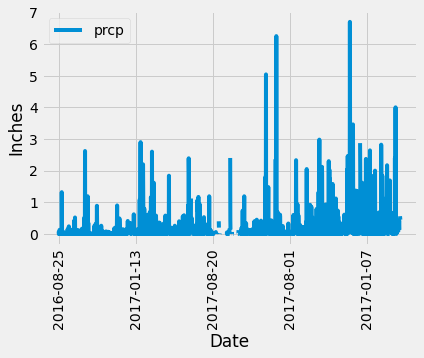

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
#Using only date and prcp columns
measurement_df.plot(y='prcp',rot=90, xlabel='Date', ylabel='Inches', use_index=True)

#plt.xticks(measurement_df['date'], labels, rotation='vertical')
plt.show()


In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [20]:
# Design a query to show how many stations are available in this dataset?
station_q = session.query(Measurement.station).distinct().count()
station_q

9

In [21]:
stations_df = pd.read_sql(session.query(Measurement.station.distinct()).statement, engine)
stations_df

,anon_1
0,USC00519397
1,USC00513117
2,USC00514830
3,USC00517948
4,USC00518838
5,USC00519523
6,USC00519281
7,USC00511918
8,USC00516128


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query=(session.query(Measurement.station, func.count(Measurement.station))
       .group_by(Measurement.station)
       .order_by(func.count(Measurement.station).desc())
      )

In [23]:
station_m_df = pd.read_sql(query.statement, engine )
station_m_df

,station,count_1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [24]:
#The most active station:
station_id = query.first()
station_id[0]

'USC00519281'

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_query = (
    session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), 
                  func.avg(Measurement.tobs))
                .filter(Measurement.station==station_id[0])
)

#Visualizing through Pandas
pd.read_sql(temp_query.statement, engine)


,station,min_1,max_1,avg_1
0,USC00519281,54.0,85.0,71.663781


In [40]:
# Choose the station with the highest number of temperature observations in last 12 months
# Using previous calculated start and end date
filter_tobs = func.count(Measurement.tobs).label('num_temp')
stations_ht = (session.query(Measurement.station, filter_tobs)
               .group_by(Measurement.station)
               
              )
stations_ht

In [41]:
station_high_temp=pd.read_sql(stations_ht.statement, engine)
station_high_temp

,station,num_temp
0,USC00511918,1979
1,USC00513117,2709
2,USC00514830,2202
3,USC00516128,2612
4,USC00517948,1372
5,USC00518838,511
6,USC00519281,2772
7,USC00519397,2724
8,USC00519523,2669


In [59]:
# Choose the station with the highest number of temperature observations in last 12 months
#This is a nested query
#Inner query
filter_tobs = func.count(Measurement.tobs).label('count_tobs')
stations_ht = session.query(Measurement, filter_tobs).group_by(Measurement.station).label("max_temp")

query_str = "select station, max(count_tobs) from (select station, count(tobs) as count_tobs from measurement group by station) as tobs_occurrences"

#Using execute to get the station having max occurrences
results = session.execute(query_str)
station_max_temp_id = results.first()[0]
station_max_temp_id


'USC00519281'

In [74]:
# Query the last 12 months of temperature observation data for this station 
max_temp = (
            session.query(Measurement.tobs)
            .filter_by(station=station_max_temp_id)
            .filter(Measurement.date>=start_date)
            .filter(Measurement.date<=end_date)
            )
    
station_max_temp=pd.read_sql(max_temp.statement, engine)
station_max_temp

,tobs
0,80.0
1,80.0
2,75.0
3,73.0
4,78.0
...,...
345,77.0
346,77.0
347,76.0
348,76.0


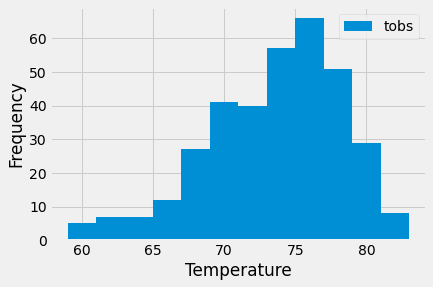

In [77]:
#and plot the results as a histogram
station_max_temp.plot.hist(by="tobs", bins=12)
plt.xlabel("Temperature")

plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
